In [ ]:
# ✅ Install dependencies
!pip install -q scikit-learn numpy pandas

In [ ]:
# ✅ Imports
import os
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ✅ Set path to your model softmax outputs
base_path = "/content/drive/MyDrive/MultiBanFake/BanglaBert"

In [ ]:
# ✅ Final 6 models selected
final_model_list = [
    "banglabert_large",
    "banglabert-sentiment",
    "banglabert",
    "banglabert-finetuned-sc",
    "bangla-bert-base",
    "bangla-bert-base-finetuned-tweets"
]

In [ ]:
# ✅ Required file names
required_files = ["train_softmax.npy", "val_softmax.npy", "test_softmax.npy"]

# ✅ Run checker
print("📁 Checking softmax files for each model...\n")

for model in final_model_list:
    print(f"🔍 {model}:")
    model_path = os.path.join(base_path, model)
    all_exist = True
    for fname in required_files:
        fpath = os.path.join(model_path, fname)
        if not os.path.exists(fpath):
            print(f"  ❌ Missing: {fname}")
            all_exist = False
    if all_exist:
        print("  ✅ All softmax files found!")
    print()


📁 Checking softmax files for each model...

🔍 banglabert_large:
  ✅ All softmax files found!

🔍 banglabert-sentiment:
  ✅ All softmax files found!

🔍 banglabert:
  ✅ All softmax files found!

🔍 banglabert-finetuned-sc:
  ✅ All softmax files found!

🔍 bangla-bert-base:
  ✅ All softmax files found!

🔍 bangla-bert-base-finetuned-tweets:
  ✅ All softmax files found!



In [ ]:
# ✅ Load all softmax outputs
def load_probs(split):
    probs_list = []
    for model in final_model_list:
        path = os.path.join(base_path, model, f"{split}_softmax.npy")
        probs = np.load(path)
        probs_list.append(probs)
    return np.concatenate(probs_list, axis=1)

X_train = load_probs("train")
X_val = load_probs("val")
X_test = load_probs("test")


In [ ]:
# ✅ Load true labels (same for all)
label_path = os.path.join(base_path, final_model_list[0])  # pick any model folder
y_train = np.load(os.path.join(label_path, "train_softmax.npy")).shape[0] * [None]  # dummy


In [ ]:
# Load from original train file
df = pd.read_csv("/content/drive/MyDrive/MultiBanFake/Dataset/text/Train.csv")
y_train = df["label"].values

df = pd.read_csv("/content/drive/MyDrive/MultiBanFake/Dataset/text/Validation.csv")
y_val = df["label"].values

df = pd.read_csv("/content/drive/MyDrive/MultiBanFake/Dataset/text/Test.csv")
y_test = df["label"].values

print(f"✅ X shape: {X_train.shape}, y: {y_train.shape}")

✅ X shape: (7680, 12), y: (7680,)


In [ ]:
# ✅ Train MLP Meta Classifier
mlp = MLPClassifier(hidden_layer_sizes=(64,), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)


MLPClassifier(hidden_layer_sizes=(64,), max_iter=1000, random_state=42)

In [ ]:
# ✅ Evaluate on Validation
val_preds = mlp.predict(X_val)
print("📊 Validation Performance:")
print(classification_report(y_val, val_preds, digits=4))


📊 Validation Performance:
              precision    recall  f1-score   support

           0     0.8397    0.8292    0.8344       480
           1     0.8313    0.8417    0.8364       480

    accuracy                         0.8354       960
   macro avg     0.8355    0.8354    0.8354       960
weighted avg     0.8355    0.8354    0.8354       960



In [ ]:
# ✅ Final Test Evaluation
test_preds = mlp.predict(X_test)
print("📊 Test Performance (Ensemble Model):")
print(classification_report(y_test, test_preds, digits=4))


📊 Test Performance (Ensemble Model):
              precision    recall  f1-score   support

           0     0.8229    0.8521    0.8373       480
           1     0.8467    0.8167    0.8314       480

    accuracy                         0.8344       960
   macro avg     0.8348    0.8344    0.8343       960
weighted avg     0.8348    0.8344    0.8343       960



In [ ]:
# ✅ Save model for reuse
import joblib
os.makedirs("/content/drive/MyDrive/MultiBanFake/StackingModel", exist_ok=True)
joblib.dump(mlp, "/content/drive/MyDrive/MultiBanFake/StackingModel/stacking_mlp_model.pkl")
np.save("/content/drive/MyDrive/MultiBanFake/StackingModel/test_preds.npy", test_preds)

<ipython-input-15-542153061>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Model", y="Weighted F1-score", palette="mako")
<ipython-input-15-542153061>:38: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


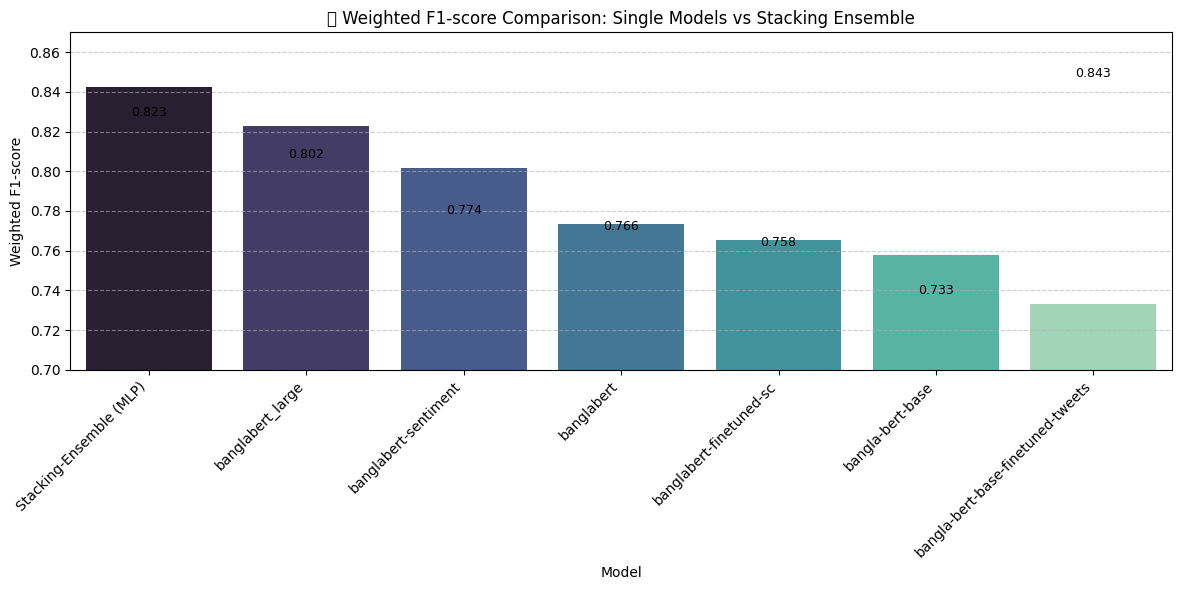

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ✅ Paste your final evaluation results here manually or load from earlier comparison
single_model_results = {
    "banglabert_large": 0.8228,
    "banglabert-sentiment": 0.8018,
    "banglabert": 0.7736,
    "banglabert-finetuned-sc": 0.7656,
    "bangla-bert-base": 0.7576,
    "bangla-bert-base-finetuned-tweets": 0.7331,
}

# ✅ Add final ensemble result (use your real number from MLP output)
stacking_f1 = 0.8425  # ⬅️ Replace with actual stacking Weighted F1-score
single_model_results["Stacking-Ensemble (MLP)"] = stacking_f1

# ✅ Create DataFrame
df = pd.DataFrame({
    "Model": list(single_model_results.keys()),
    "Weighted F1-score": list(single_model_results.values())
}).sort_values("Weighted F1-score", ascending=False)

# ✅ Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="Model", y="Weighted F1-score", palette="mako")
plt.xticks(rotation=45, ha="right")
plt.title("📊 Weighted F1-score Comparison: Single Models vs Stacking Ensemble")
plt.ylabel("Weighted F1-score")
plt.ylim(0.7, 0.87)
plt.grid(axis="y", linestyle="--", alpha=0.6)

for index, row in df.iterrows():
    plt.text(index, row["Weighted F1-score"] + 0.005, f"{row['Weighted F1-score']:.3f}",
             ha='center', fontsize=9, color='black')

plt.tight_layout()
plt.show()


/tmp/ipython-input-4-4125265542.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Model", y="Weighted F1-score", palette="mako")
/tmp/ipython-input-4-4125265542.py:40: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


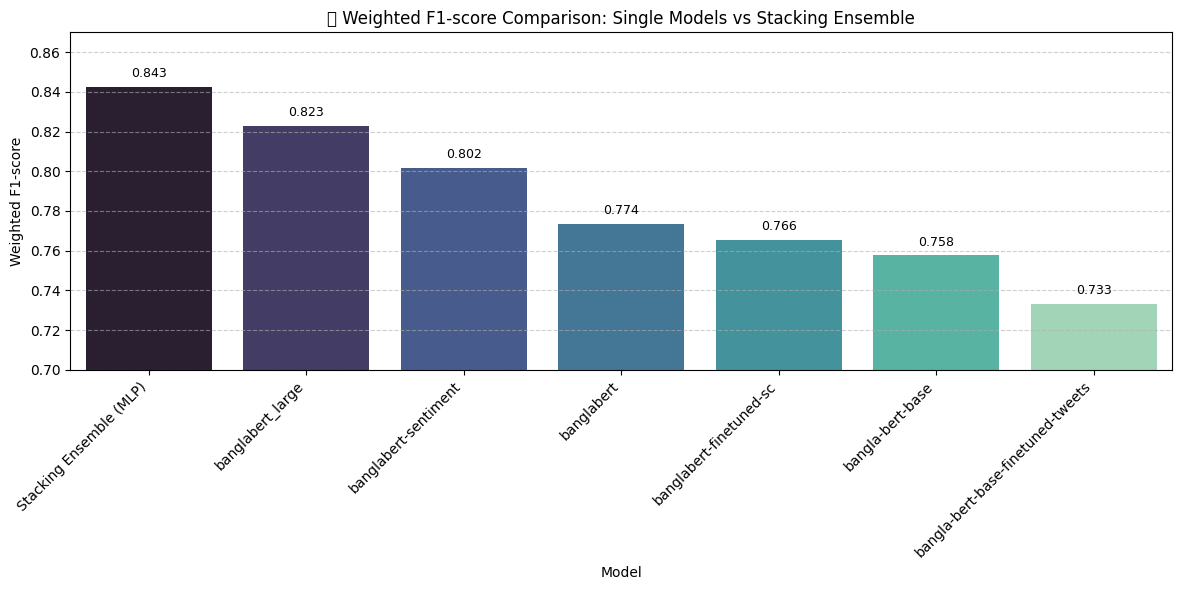

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ✅ Final evaluation results
single_model_results = {
    "banglabert_large": 0.8228,
    "banglabert-sentiment": 0.8018,
    "banglabert": 0.7736,
    "banglabert-finetuned-sc": 0.7656,
    "bangla-bert-base": 0.7576,
    "bangla-bert-base-finetuned-tweets": 0.7331,
}

# ✅ Correct Stacking Ensemble F1-score
stacking_f1 = 0.8425  # ✅ Replace this with your actual best MLP result
single_model_results["Stacking Ensemble (MLP)"] = stacking_f1

# ✅ Create DataFrame
df = pd.DataFrame({
    "Model": list(single_model_results.keys()),
    "Weighted F1-score": list(single_model_results.values())
}).sort_values("Weighted F1-score", ascending=False).reset_index(drop=True)

# ✅ Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="Model", y="Weighted F1-score", palette="mako")
plt.xticks(rotation=45, ha="right")
plt.title("📊 Weighted F1-score Comparison: Single Models vs Stacking Ensemble")
plt.ylabel("Weighted F1-score")
plt.ylim(0.7, 0.87)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# ✅ Add exact F1-score values on top of each bar
for i in range(len(df)):
    plt.text(i, df.loc[i, "Weighted F1-score"] + 0.005,
             f'{df.loc[i, "Weighted F1-score"]:.3f}',
             ha='center', fontsize=9, color='black')

plt.tight_layout()
plt.show()
